# Update

This tutorial was originally written for MIMIC 2, but I have updated the code for MIMIC 3. I have left some of the links which still refer to MIMIC 2 because they still have value.


# Where to Start

After reading my [Guide to Getting Started with the MIMIC Data](http://nbviewer.ipython.org/github/tfolkman/mimic_data/blob/master/Getting_Started_with_MIMIC_Demo.ipynb) you might be wondering where to start to use the MIMIC data to do your own research. In this notebook I will try and provide some guidance as to how to navigate the MIMIC data. I will discuss the "most important tables" and some SQL code to get item ids.

Most of this is from the [MIMIC Primer 201](http://criticaldata.mit.edu/scope-of-mimic/) and the [MIMIC Primer 301](http://criticaldata.mit.edu/mimic-primer-201/). I am mostly just providing some code.

# Most Important Tables

* The **ICU Stay Detail table** has data pertaining to a unique admission to the ICU. This table was removed in MIMIC III, but can be partially re-created using code found below.

* The **Chart Events table** contains data on the vital signs that get recorded by clinical staff. This includes blood pressure, body temperature, heart rate, and many more.

* Finally, the **Lab Events table** contains data about the specific lab tests that were performed. So if you want information on something like a patient’s serum glucose levels, white blood cell counts, or serum potassium levels, you’d want to use this table.

Lets take a quick look at the data in these tables.

### Note:
For this code to work, you need to fill in values for the dbname, user, and pswd.

In [1]:
import psycopg2
import pandas.io.sql as psql
import seaborn as sns
sns.set(style='ticks', palette='Set2')
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division #now division always returns a floating point number

dbname = 'mimic'
user = 'mimic'
pswd = 'mimic'

#note: assumes data on localhost

db = psycopg2.connect("dbname={0} host='localhost' user={1} password={2}".format(dbname, user, pswd))

# ICU Stay Detail
This table was removed in MIMIC III, but can be somewhat re-created with the code below (source [here](https://github.com/MIT-LCP/mimic-code/blob/master/demographics/postgres/icustay_details.sql#L8))

In [2]:
icustay_detail = psql.read_sql("""
with co as (
select ie.subject_id, ie.hadm_id, ie.icustay_id
, pat.gender
, adm.ethnicity
, adm.ADMISSION_TYPE
, adm.admittime, adm.dischtime
, case
when adm.deathtime is not null then 'Y'
else 'N'
end
as hospital_expire_flag
, row_number() over (partition by ie.subject_id, ie.hadm_id order by ie.intime) as hospstay_num
, case
when row_number() over (partition by ie.subject_id, ie.hadm_id order by ie.intime) = 1 then 'Y'
else 'N'
end
as first_hosp_stay
, ie.intime, ie.outtime
, round((EXTRACT(EPOCH FROM (ie.intime-pat.dob)) / 60 / 60 / 24 / 365.242) :: NUMERIC, 4) as Age
, round((EXTRACT(EPOCH FROM (ie.outtime - ie.intime)) / 60 / 60 / 24) :: NUMERIC, 4) as LOS_ICU
, row_number() over (partition by ie.subject_id, ie.hadm_id order by ie.intime) as icustay_num
from mimiciii.icustays ie
inner join mimiciii.admissions adm
on ie.hadm_id = adm.hadm_id
inner join mimiciii.patients pat
on ie.subject_id = pat.subject_id
where adm.has_chartevents_data = 1
)
select co.*
from co
order by co.subject_id, co.admittime, co.intime limit 5;""", con=db)
print("Table: icustay_detail\n")
print("Shape: {}\n".format(icustay_detail.shape))
print("Columns: {}".format(icustay_detail.columns))

Table: icustay_detail

Shape: (5, 16)

Columns: Index([u'subject_id', u'hadm_id', u'icustay_id', u'gender', u'ethnicity', u'admission_type', u'admittime', u'dischtime', u'hospital_expire_flag', u'hospstay_num', u'first_hosp_stay', u'intime', u'outtime', u'age', u'los_icu', u'icustay_num'], dtype='object')


# Chartevents and Labevents

In [3]:
tables = ['chartevents', 'labevents']

for table in tables:
    table_data = psql.read_sql("select * from mimiciii.{} limit 5;".format(table), con=db)
    print("Table: {}\n".format(table))
    print("Shape: {}\n".format(table_data.shape))
    print("Columns: {}".format(table_data.columns))
    print("***********************")

Table: chartevents

Shape: (5, 15)

Columns: Index([u'row_id', u'subject_id', u'hadm_id', u'icustay_id', u'itemid', u'charttime', u'storetime', u'cgid', u'value', u'valuenum', u'uom', u'warning', u'error', u'resultstatus', u'stopped'], dtype='object')
***********************
Table: labevents

Shape: (5, 9)

Columns: Index([u'row_id', u'subject_id', u'hadm_id', u'itemid', u'charttime', u'value', u'valuenum', u'uom', u'flag'], dtype='object')
***********************


## Some Observations

Above we can see that the ICUSTAY DETAIL table has 16 columns. As you can see from the column names, there are a lot of interesting data in this table. 

We can see that the CHART EVENTS and LAB EVENTS can be connected to the ICUSTAY DETAIL using the subject_id, icustay_id, and hadm_id variables. 

Also, both the event tables follow the pattern of an itemid, charttime, and valuenum. The itemid is a number and can be used to look up the description of that event in a dictionary table. For example, the dictionary table for CHART EVENTS is D_ITEMS. If you look up itemid 211 in D_CHARTITEMS you will see that it corresponds to heart rate. Thus, a valuenum with an itemid of 211 in the CHART EVENTS table is a heart rate reading. Nice.

But how can we figure out the itemids for our events of interest? The following code will make this process much easier.

# Function to get Relevant Item Ids

The code I have below pulls from many of the event tables and connects them to their dictionary tables. This code is extremely useful becuase it allows you to provide a search query such as 'temp' and then returns all the itemids with a description that includes your search text. It is also very important to know that an event might have multiple itemids. For example, you can see below that our search for 'temp' returned itemids for temperature in C and F. Once the SQL code runs, I return some stats on the results with the top 10 itemids and a histogram. Hope this little primer on where to start helps you more effectively utilize the MIMIC data.

## Pulls from:
* Lab Events
* Output Events
* Input Events (CV and MV)
* Chart Events
* Procedure Events

In [4]:
search_query = 'temp'


itemids = psql.read_sql("""

WITH RAW_DATA as (

SELECT ev.ITEMID AS ITEMID,
    di.LABEL AS LABEL,
    'LABEVENTS' AS SOURCE
FROM MIMICIII.labevents ev
    JOIN MIMICIII.d_labitems di
    ON di.ITEMID = ev.ITEMID
WHERE upper(di.LABEL) LIKE '%{0}%'

UNION ALL

SELECT ev.ITEMID AS ITEMID,
    di.LABEL AS LABEL,
    'OUTPUTEVENTS' AS SOURCE
FROM MIMICIII.outputevents ev
    JOIN MIMICIII.d_items di
    ON di.ITEMID = ev.ITEMID
WHERE upper(di.LABEL) LIKE '%{0}%'

UNION ALL

SELECT ev.ITEMID AS ITEMID,
    di.LABEL AS LABEL,
    'INPUTEVENTS_CV' AS SOURCE
FROM MIMICIII.INPUTEVENTS_CV ev
    JOIN MIMICIII.d_items di
    ON di.ITEMID = ev.ITEMID
WHERE upper(di.LABEL) LIKE '%{0}%'

UNION ALL

SELECT ev.ITEMID AS ITEMID,
    di.LABEL AS LABEL,
    'INPUTEVENTS_MV' AS SOURCE
FROM MIMICIII.INPUTEVENTS_MV ev
    JOIN MIMICIII.d_items di
    ON di.ITEMID = ev.ITEMID
WHERE upper(di.LABEL) LIKE '%{0}%'

UNION ALL

SELECT ev.ITEMID AS ITEMID,
    di.LABEL AS LABEL,
    'CHARTEVENTS' AS SOURCE
FROM MIMICIII.chartevents ev
    JOIN MIMICIII.d_items di
    ON di.ITEMID = ev.ITEMID
WHERE upper(di.LABEL) LIKE '%{0}%'

UNION ALL

SELECT ev.ITEMID AS ITEMID,
    di.LABEL AS LABEL,
    'PROCEDUREEVENTS' AS SOURCE
FROM MIMICIII.procedureevents_mv ev
    JOIN MIMICIII.d_items di
    ON di.ITEMID = ev.ITEMID
WHERE upper(di.LABEL) LIKE '%{0}%'
)

select itemid, label, source, count(*) as cnt
from raw_data
group by itemid, label, source
order by cnt desc

;

""".format(search_query.upper()), con = db)

In [5]:
print("Shape: {}".format(itemids.shape))
print("*****************")
print(itemids.source.value_counts())
print("*****************")
print(itemids.cnt.describe())
print("*****************")
itemids.head(n=10)

Shape: (57, 4)
*****************
CHARTEVENTS        53
PROCEDUREEVENTS     3
LABEVENTS           1
dtype: int64
*****************
count         57.000000
mean      140890.175439
std       256311.018219
min            1.000000
25%          146.000000
50%        10051.000000
75%       124630.000000
max      1045009.000000
Name: cnt, dtype: float64
*****************


,itemid,label,source,cnt
0,674,Temp. Site,CHARTEVENTS,1045009
1,3656,Temp/Iso/Warmer [Type],CHARTEVENTS,803917
2,678,Temperature F,CHARTEVENTS,775928
3,677,Temperature C (calc),CHARTEVENTS,774312
4,8537,"Temp/Iso/Warmer [Temperature, degrees C]",CHARTEVENTS,725887
5,3655,Temp Skin [C],CHARTEVENTS,533002
6,223761,Temperature Fahrenheit,CHARTEVENTS,522143
7,3652,Temp Axillary [F],CHARTEVENTS,461999
8,676,Temperature C,CHARTEVENTS,379232
9,679,Temperature F (calc),CHARTEVENTS,376716


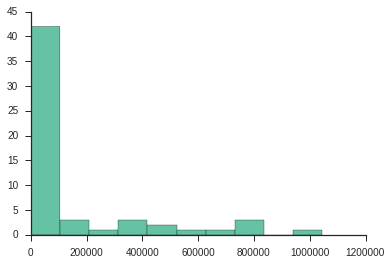

In [6]:
plt.hist(itemids.cnt)
sns.despine()